In [1]:
! pip install onnx 
! pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 90.6 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
import os
import sys
from torch.utils.data import DataLoader, Dataset
import math
from torchvision.transforms import v2
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from torch.autograd import Variable
from torchvision import models,transforms
from transformers import pipeline
import torchvision.transforms.functional as TF
import onnx
import onnxruntime
from onnxruntime.quantization import quantize_dynamic, quantize_static, QuantType, QuantFormat, create_calibrator, CalibrationMethod, CalibrationDataReader
from transformers import AutoImageProcessor, AutoModelForDepthEstimation, AutoConfig
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
class CustomDataset(Dataset): 
    
    def __init__(self, path, device, transform=None, img_size=(128, 128)):
        super(CustomDataset, self).__init__()
        self.device = device
        self.images = []
        self.labels = []
        self.img_size = img_size
        self.transform = transform
        self.path = path
        self.num_channels = 1
        
        for folder in os.listdir(self.path):
            label = 1 if 'client' in folder else 0
            for image in os.listdir(os.path.join(self.path, folder)):
                if image.endswith('.jpg') or image.endswith('.png'):
                    img_path = os.path.join(self.path, folder, image)
                    self.images.append(img_path)
                    self.labels.append(label)
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")

        if self.transform:
            img= self.transform(img)
            
        return img, self.labels[idx]

In [4]:
img_size = (252, 252)
batch_size = 10
transf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.Resize(img_size),
    transforms.ToTensor()
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

test_dataset = CustomDataset("/kaggle/input/increased-liveliness-detection/test",device,transf,img_size=img_size)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [5]:
class FineTuneDepthAnything(nn.Module):
    def __init__(self, device,load_trained=False,model_path=None):
        super(FineTuneDepthAnything, self).__init__()
        if load_trained:
            config = AutoConfig.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
            self.depth_anything = AutoModelForDepthEstimation.from_config(config)
            state_dict = torch.load(model_path, map_location=device,weights_only=True)
                
            # Adjust keys in the state dictionary to match the model's keys
            new_state_dict = {}
            for key, value in state_dict.items():
                new_key = key.replace("depth_anything.", "")
                new_state_dict[new_key] = value

            # Load the adjusted state dictionary into the model
            self.depth_anything.load_state_dict(new_state_dict)
        else:
            self.depth_anything = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
            for name,param in self.depth_anything.named_parameters():
                if 'head' in name or 'neck.fusion_stage.layers.2.residual_layer' in name or 'neck.fusion_stage.layers.3' in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        
        self.depth_anything = self.depth_anything.to(device)
                
    def forward(self, inp):
        # print(f'inp shape: {inp.shape}')
        return self.depth_anything(inp).predicted_depth.unsqueeze(1)

In [6]:
class CDC(nn.Module):
    '''
    This class performs central difference convolution (CDC) operation. First the normal convolution is performed and then the difference convolution is performed. The output is the difference between the two is taken.
    '''
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1,
                 padding=1, dilation=1, groups=1, bias=False, theta=0.7):

        super(CDC, self).__init__()
        self.bias= bias
        self.stride = stride
        self.groups = groups
        self.dilation = dilation
        self.theta = theta
        self.padding = padding
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels))
        else:
            self.bias = None
            
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding if kernel_size==3 else 0, dilation=dilation, groups=groups, bias=bias)

    def forward(self, x):
        out_normal = self.conv(x)
        # if conv.weight is (out_channels, in_channels, kernel_size, kernel_size),
        # then the  self.conv.weight.sum(2) will return (out_channels, in_channels,kernel_size)
        # and self.conv.weight.sum(2).sum(2) will return (out_channels,n_channels)
        kernel_diff = self.conv.weight.sum(2).sum(2)
        # Here we are adding extra dimensions such that the kernel_diff is of shape (out_channels, in_channels, 1, 1) so that convolution can be performed.
        kernel_diff = kernel_diff[:, :, None, None]
        out_diff = F.conv2d(input=x, weight=kernel_diff, bias=self.bias, stride=self.stride, padding=0, groups=self.groups)
        return out_normal - self.theta * out_diff
        

In [7]:
class conv_block_nested(nn.Module):
    def __init__(self, in_ch,  out_ch):
        super(conv_block_nested, self).__init__()
        self.activation = nn.ReLU(inplace=True)
        self.conv1 = CDC(in_ch, out_ch, kernel_size=3, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = CDC(out_ch, out_ch, kernel_size=3, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        output = self.activation(x)

        return output

In [ ]:
class ClassifierUCDCN(nn.Module):
    def __init__(self, dropout=0.5):
        super(ClassifierUCDCN, self).__init__()
        self.layers =8
        self.dropout_prob = dropout
        self.img_size = (252, 252)
        self.hidden_size = 64
        self.conv1 = conv_block_nested(1,self.layers)
        self.relu = nn.ReLU()
        self.maxpool = nn.AvgPool2d(kernel_size=2,stride=2)
        self.conv2 = conv_block_nested(self.layers,1)
        # Maxpool
        self.linear_1 = nn.Linear((self.img_size[0]//4 * self.img_size[1]//4), self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_prob)
        self.linear_2 = nn.Linear(self.hidden_size, 2)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, inp):
        conv1 = self.conv1(inp)
        maxpool = self.maxpool(conv1)
        conv2 = self.conv2(maxpool)
        maxpool2 = self.maxpool(conv2)
        linear_1 = self.linear_1(maxpool2.view(-1, self.img_size[0]//4 * self.img_size[1]//4))
        relu = self.relu(linear_1)
        dropout = self.dropout(relu)
        linear_2 = self.linear_2(dropout)
        return self.sigmoid(linear_2)

In [9]:
depth_map_model = FineTuneDepthAnything(device, load_trained=True, model_path='/kaggle/input/finetune_depth_anything/pytorch/63_epochs_trained/1/fine_tuning_depth_anything.pth').to(device)
depth_map_model.eval()
classifier = ClassifierUCDCN(dropout=0.5).to(device)
classifier.load_state_dict(torch.load('/kaggle/input/finetune_depth_anyhting_classifier/pytorch/64_size_7_epochs_trained/1/64_finetune_depth_anything_classifier.pth',map_location=device,weights_only=True))
classifier.eval()

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

ClassifierUCDCN(
  (conv1): conv_block_nested(
    (activation): ReLU(inplace=True)
    (conv1): CDC(
      (conv): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): CDC(
      (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
  (maxpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): conv_block_nested(
    (activation): ReLU(inplace=True)
    (conv1): CDC(
      (conv): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (bn1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): CDC(
      (conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (bn2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [10]:
def run_inference(session, input_data):
    """Run inference using ONNX Runtime session"""
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    
    result = session.run([output_name], {input_name: input_data})
    return result[0]

In [11]:
def create_inference_session(quantized_model_path,provider='CPUExecutionProvider'):
    """Create ONNX Runtime inference session"""
    # Set up ONNX Runtime options for Processor (Raspberry Pi)
    options = onnxruntime.SessionOptions()
    # options.intra_op_num_threads = 4  # Adjust based on your Raspberry Pi's CPU
    options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL
    
    # Create inference session
    session = onnxruntime.InferenceSession(
        quantized_model_path,
        options,
        providers=[provider]
    )
    return session

In [ ]:
provider = 'CUDAExecutionProvider'
depth_normal_session = create_inference_session('/kaggle/input/m/onnx_models/onnx/64_hidden_quantized/1/depth_map_model.onnx')
classifier_normal_session = create_inference_session('/kaggle/input/m/onnx_models/onnx/64_hidden_quantized/1/classifier_model.onnx')

In [ ]:
depth_onnx = onnx.load('/kaggle/input/m/onnx_models/onnx/64_hidden_quantized/1/depth_quantized_model.onnx')
onnx.checker.check_model(depth_onnx)

In [ ]:
classifier_onnx = onnx.load('/kaggle/input/m/onnx_models/onnx/64_hidden_quantized/1/classifier_quantized_model.onnx')
onnx.checker.check_model(classifier_onnx)

In [ ]:
provider = 'CUDAExecutionProvider'
depth_quantized_session = create_inference_session('/kaggle/input/m/onnx_models/onnx/64_hidden_quantized/1/depth_quantized_model.onnx')
classifier_quantized_session = create_inference_session('/kaggle/input/m/onnx_models/onnx/64_hidden_quantized/1/classifier_quantized_model.onnx')

In [ ]:
def convert_to_numpy(pt_tensor):
    return pt_tensor.numpy()

In [21]:
def display_accuracy(correct,total,all_labels,all_predictions,name):
    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f'{name}: Accuracy on the test images: {accuracy:.2f} %')
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    
    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{name}: Confusion Matrix')
    plt.show()

In [22]:
# Pytorch
correct_torch = 0
total_torch = 0
all_labels_torch = []
all_predictions_torch = []

# ONNX without Qunatization
correct_without_quantization = 0
total_without_quantization = 0
all_labels_without_quantization = []
all_predictions_without_quantization = []

# ONNX with Quantization
correct_with_quantization = 0
total_with_quantization = 0
all_labels_with_quantization = []
all_predictions_with_quantization = []


with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images_device, labels_device = images.to(device), labels.to(device)

        # Torch
        depth_maps = depth_map_model(images_device)
        outputs = classifier(depth_maps)
        predicted = torch.argmax(outputs, 1)
        total_torch += labels_device.size(0)
        correct_torch += (predicted == labels_device).sum().item()
        all_labels_torch.extend(labels_device.cpu().numpy())
        all_predictions_torch.extend(predicted.cpu().numpy())

        # Without quantization
        without_inputs = {depth_normal_session.get_inputs()[0].name: convert_to_numpy(images)}
        without_depth_maps = depth_normal_session.run(None, without_inputs)[0]
        map_inputs = {classifier_normal_session.get_inputs()[0].name: without_depth_maps}
        without_outputs = classifier_normal_session.run(None,map_inputs)[0]

        without_predicted = np.argmax(without_outputs, 1)
        total_without_quantization += labels.size(0)
        correct_without_quantization += np.sum(without_predicted == convert_to_numpy(labels))
        all_labels_without_quantization.extend(labels)
        all_predictions_without_quantization.extend(without_predicted)

        # With quantization
        with_inputs = {depth_quantized_session.get_inputs()[0].name: convert_to_numpy(images)}
        with_depth_maps = depth_quantized_session.run(None, with_inputs)[0]

        with_map_inputs = {classifier_quantized_session.get_inputs()[0].name: with_depth_maps}
        with_outputs = classifier_quantized_session.run(None,with_map_inputs)[0]

        with_predicted = np.argmax(with_outputs, 1)
        total_with_quantization += labels.size(0)
        correct_with_quantization += np.sum(with_predicted == convert_to_numpy(labels))
        all_labels_with_quantization.extend(labels)
        all_predictions_with_quantization.extend(with_predicted)

Torch: Accuracy on the test images: 94.44 %


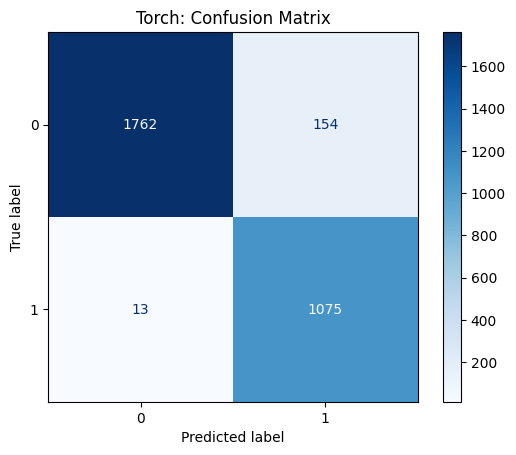

In [23]:
display_accuracy(correct_torch,total_torch,all_labels_torch,all_predictions_torch,'Torch')

ONNX without quantization: Accuracy on the test images: 94.44 %


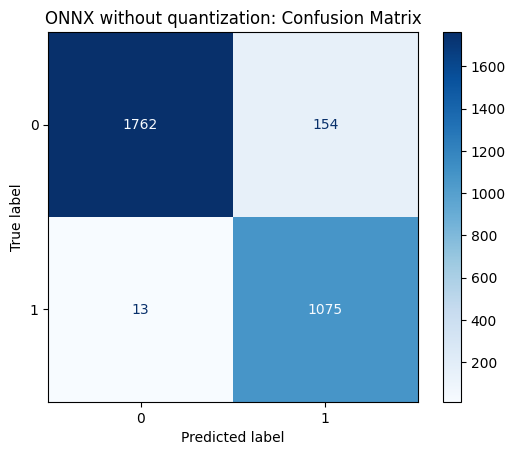

In [24]:
display_accuracy(correct_without_quantization,total_without_quantization,all_labels_without_quantization,all_predictions_without_quantization,'ONNX without quantization')

ONNX with quantization: Accuracy on the test images: 94.97 %


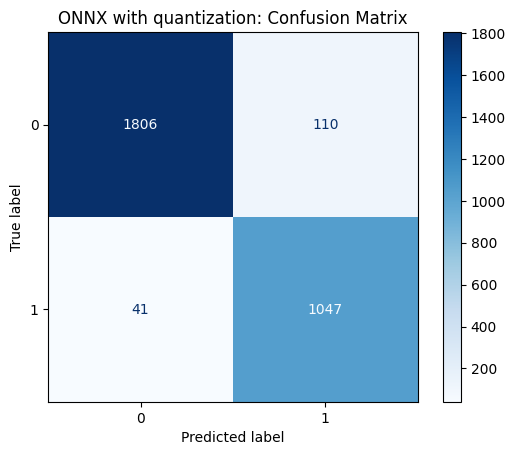

In [25]:
display_accuracy(correct_with_quantization,total_with_quantization,all_labels_with_quantization,all_predictions_with_quantization,'ONNX with quantization')